# Conditional GAN (cGAN) — Bug-Fix Labs - 10 Bugs to Fix

In [47]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------------------------
# Data  (MNIST 28×28 → 32×32)
# ---------------------------
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()                 # BUG
])
ds = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
loader = DataLoader(ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

# ---------------------------
# Hyperparams
# ---------------------------
z_dim = 128
emb_dim = 50
num_classes = 10
g_lr  = 2e-4   # BUG
d_lr  = 2e-5   # BUG

# ---------------------------
# Models
# ---------------------------
class CGAN_G(nn.Module):
    def __init__(self, z=128, emb_dim=50, num_classes=10, ch=64):
        super().__init__()
        self.embed = nn.Embedding(num_classes, emb_dim)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z + emb_dim, ch*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ch*4), nn.ReLU(True),
            nn.ConvTranspose2d(ch*4, ch*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ch*2), nn.ReLU(True),
            nn.ConvTranspose2d(ch*2, ch,   4, 2, 1, bias=False),
            nn.BatchNorm2d(ch),   nn.ReLU(True),
            nn.ConvTranspose2d(ch, 1,      4, 2, 1, bias=False)
            # BUG
        )
    def forward(self, z, y):
        e = self.embed(y)                          # (B, emb_dim)
        # BUG
        inp = torch.cat([z, e], dim=-1)             # WRONG
        x = inp.view(inp.size(0), -1, 1, 1)        # will mismatch conv
        return self.net(x)

class CGAN_D(nn.Module):
    def __init__(self, emb_dim=50, num_classes=10, ch=64):
        super().__init__()
        self.embed = nn.Embedding(num_classes, emb_dim)
        self.img = nn.Sequential(
            nn.Conv2d(1, ch, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ch, ch*2, 4, 2, 1), nn.BatchNorm2d(ch*2), nn.LeakyReLU(0.2, True),
        )
        self.fc = nn.Sequential(
            nn.Linear(ch*2*8*8 + emb_dim, 1),
            #nn.Sigmoid()                           # BUG
        )
    def forward(self, x, y):
        h = self.img(x).view(x.size(0), -1)
        e = self.embed(y)
        return self.fc(torch.cat([h, e], dim=1)).view(x.size(0))

G = CGAN_G(z_dim, emb_dim, num_classes).to(device)
D = CGAN_D(emb_dim, num_classes).to(device)

# ---------------------------
# Loss & Optimizers
# ---------------------------
crit = nn.BCEWithLogitsLoss()
optD = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(0.4, 0.999))   # BUG
optG = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.4, 0.999))   # BUG

# ---------------------------
# Training loop (intentionally wrong)
# ---------------------------
def train_one_epoch(loader):
 for real, y in loader:
    real = real.to(device)
    # BUG
    y = y.to(device)                  # WRONG

    b = real.size(0)
    z = torch.randn(b, z_dim, device=device)

    # ---- D step ----
    fake = G(z, y).detach()                             # BUG
    # BUG
    lossD = crit(D(real, y), torch.zeros(b, device=device)) + \
            crit(D(fake, y), torch.ones (b, device=device))

    lossD.backward()
    optD.step()                                   # BUG
    optD.zero_grad()



    # ---- G step ----
    z = torch.randn(b, z_dim, device=device)
    fake = G(z, y)
    # BUG
    lossG = crit(D(fake,y),  # BUG
                 torch.zeros(b, device=device))

    lossG.backward()
    optG.step()
    optG.zero_grad()

    return lossD.item(), lossG.item()



In [48]:
lossesD, lossesG = [], []
for epoch in range(10):
    lossD, lossG = train_one_epoch(loader)
    lossesD.append(lossD)
    lossesG.append(lossG)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


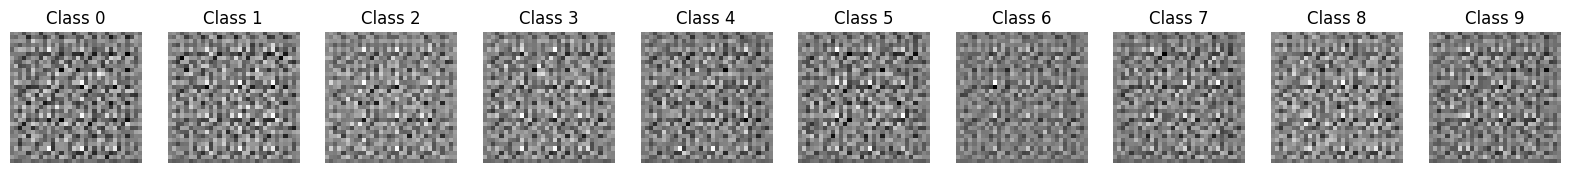

In [49]:
import matplotlib.pyplot as plt

def plot_samples(G, z_dim, num_classes, device):
    G.eval()
    with torch.no_grad():
        z = torch.randn(num_classes, z_dim, device=device)
        labels = torch.arange(num_classes, device=device)
        fake_imgs = G(z, labels)
        fake_imgs = (fake_imgs.cpu())

    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes*2, 2))
    for i in range(num_classes):
        axs[i].imshow(fake_imgs[i, 0], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"Class {i}")
    plt.show()


plot_samples(G, z_dim, num_classes, device)
